In [1]:
# Importing LIb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
test = pd.read_csv('test.csv')
data = pd.read_csv('train.csv')

In [3]:
#test1 = test.copy()

In [4]:
#train.head()

NameError: name 'train' is not defined

In [ ]:
#print (train.shape)
#print (test.shape)

In [ ]:
#train['Heading'] = 'Train'
#test['Heading'] = 'Test'

In [ ]:
#data = pd.concat([train,test],ignore_index=True)

In [ ]:
#data.head()

In [ ]:
#data.shape

In [5]:
data.isnull().sum()

ID            0
Tag           0
Reputation    0
Answers       0
Username      0
Views         0
Upvotes       0
dtype: int64

In [6]:
#data.dtypes

In [7]:
#data['Tag'].unique()

In [8]:
#data.describe()

In [9]:
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import learning_curve,cross_val_score,validation_curve,train_test_split,KFold

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor,plot_importance
import joblib

In [10]:
#functions
def remove_by_vif(X,vif=5):
    """Remove columns from X whose VIF is greater than supplied 'vif'
    Parameters:
        X:array or dataframe containing data excluding target variable
        vif: int or float of limiting value of VIF
    Note:
        This function changes X inplace
    """
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    removed=[]
    for i in range(len(X.columns)):
        l = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        s=pd.Series(index=X.columns,data=l).sort_values(ascending=False)
        if s.iloc[0]>vif:
            X.drop(s.index[0],axis=1,inplace=True)
            print(s.index[0],', VIF: ',s.iloc[0])
            removed.append(s.index[0])
        else:
            break
    return removed
            
def plot_validation_curve(scores,param_range,param_name,scoring='r2'):
    """This function plot validation curve.
    
    Parameters:
        scores: scores obtained from validation_curve() method
        param_range: list of range of parameters passed as 'param_range' in validation_curve() method
        scoring: str
    """
    n=len(param_range)
    if scoring=='r2':
        train_score=[scores[0][i].mean() for i in range (0,n)]
        test_score=[scores[1][i].mean() for i in range (0,n)]
    elif scoring=='neg_mean_squared_error':
        train_score=[np.sqrt(-scores[0][i].mean()) for i in range (0,n)]
        test_score=[np.sqrt(-scores[1][i].mean()) for i in range (0,n)]

    fig=plt.figure(figsize=(8,6))
    plt.plot(param_range,train_score,label='Train')
    plt.plot(param_range,test_score,label='Test')
    plt.xticks=param_range
    plt.title("Validation curve of {}".format(param_name),size=12)
    plt.legend()

In [11]:
corr_matrix=data[['Reputation', 'Answers', 'Username', 'Views', 'Upvotes']].corr()

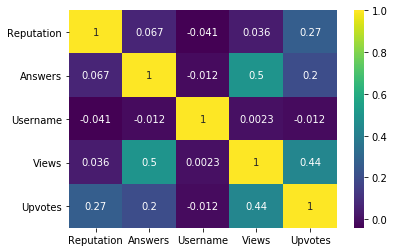

In [12]:
#no highly correlated features
#username is not at all correlated with any feature
#it has a lot of unique values. It can be ignored
sns.heatmap(corr_matrix,cmap='viridis',annot=True)

Feature Engineering
As features are very less, not much feature engineering can be done. I've done following feature engineering:
Polynomial features from numerical features
One hot encoding of Tag
Tag-wise mean of numberical features
Removing some features with high variance inflation factor. This step is necessary of Linear Regression model.

In [13]:
num_features=['Reputation', 'Answers', 'Views']

In [14]:
#1. Getting polynomial features and selecting only newly created features
poly=PolynomialFeatures(degree=2,include_bias=False)
tmp=pd.DataFrame(poly.fit_transform(data[num_features])).loc[:,len(num_features):]
data=data.join(tmp)

In [15]:
#2. Tag-wise mean of numberical features
tmp=data.groupby('Tag')[num_features].mean()
tmp.columns=tmp.columns+'_mean'
data=pd.merge(data,tmp.reset_index(),how='left',on='Tag')



In [16]:
# Username wise count of upvotes. Fill nulls with 0
uname_count=data.groupby('Username')['Upvotes'].count().reset_index()
uname_count.rename(columns={'Upvotes':'User_Upvote_Count'},inplace=True)
data=pd.merge(data,uname_count,how='left',on='Username')
data['User_Upvote_Count'].fillna(0,inplace=True)

In [17]:
data['uv']=data['Upvotes']/data['Views']
uname_uv=data.groupby('Username')['uv'].mean().reset_index()
uname_uv.rename(columns={'uv':'User_Upvote_Views_Mean'},inplace=True)
data=pd.merge(data,uname_uv,how='left',on='Username')
data['User_Upvote_Views_Mean'].fillna(0,inplace=True)

data.drop('uv',axis=1,inplace=True)

In [18]:
#3. One hot encoding of Tag
dummies=pd.get_dummies(data['Tag'],drop_first=True)
data=pd.concat([data,dummies],axis=1)
data.drop('Tag',axis=1,inplace=True)

In [19]:
X=data.drop('Upvotes',axis=1)
y=data['Upvotes']

In [20]:
#4. Check multicolinearity
removed_by_vif=remove_by_vif(X.copy())
# removed_by_vif=['p','j','c']
X=X.drop(removed_by_vif,axis=1)

/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


x , VIF:  inf
Answers_mean , VIF:  9007199254740992.0
c , VIF:  22.418724336647497
7 , VIF:  9.241929632523291


In [21]:
X.drop('ID',axis=1,inplace=True)


In [22]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=60)




In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=60)

In [24]:
#scaling
std=StandardScaler()
X_train_scaled=pd.DataFrame(std.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
X_val_scaled=pd.DataFrame(std.transform(X_val),columns=X_val.columns,index=X_val.index)
X_test_scaled=pd.DataFrame(std.transform(X_test),columns=X_test.columns,index=X_test.index)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


In [25]:
scoring='neg_mean_squared_error'

In [26]:
lr=LinearRegression()
scores=cross_val_score(lr,X_train_scaled,y_train,n_jobs=-1,cv=5,scoring=scoring)
print('RMSE: ',np.sqrt(-scores).mean())

RMSE:  1382.5869064169697


In [27]:
lr.fit(X_train_scaled,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [28]:
# Result on test
y_train_pred=lr.predict(X_train_scaled)
y_val_pred=lr.predict(X_val_scaled)
y_pred_lr=np.append(y_train_pred,y_val_pred)
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_val,y_val_pred)))


Train RMSE: 1240.551456086003
Test RMSE: 788.5020175193273


In [29]:
# Baseline Model
xgb=XGBRegressor(random_state=50)
xgb.fit(X_train_scaled,y_train)
y_train_pred=xgb.predict(X_train_scaled)
y_val_pred=xgb.predict(X_val_scaled)
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_val,y_val_pred)))

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:10:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 613.9545125119132
Test RMSE: 899.2489673714734


In [ ]:
pip install -e git://github.com/YannDubs/scikit-optimize.git#egg=scikit-optimize

In [ ]:
pip install scikit-learn==0.20.3

In [31]:
from skopt import BayesSearchCV

In [33]:
# Bayesian Optimization
opt = BayesSearchCV(
    estimator = XGBRegressor(
        n_jobs = -1,
        tree_method='approx'
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 20),
        'max_depth': (3, 5),
#         'max_delta_step': (0, 20),
        'subsample': (0.1, 1.0, 'uniform'),
        'colsample_bytree': (0.1, 1.0, 'uniform'),
        'colsample_bylevel': (0.1, 1.0, 'uniform'),
        'reg_lambda': (1e-3, 1000, 'log-uniform'),
        'reg_alpha': (1e-3, 1.0, 'log-uniform'),
#         'gamma': (1e-9, 0.5, 'log-uniform'),
        'base_score':((1e-4, 0.5, 'log-uniform'))
    },    
    scoring = scoring,
    cv =3,
    n_jobs = -1,
    refit = True,
    random_state = 42
)

opt.fit(X_train_scaled,y_train)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:56:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


BayesSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, tree_method='approx', verbosity=1),
       fit_params=None, iid=True, n_iter=50, n_jobs=-1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=42,
       refit=True, return_train_score=False,
       scoring='neg_mean_squared_error',
       search_spaces={'learning_rate': (0.01, 1.0, 'log-uniform'), 'min_child_weight': (0, 20), 'max_depth': (3, 5), 'subsample': (0.1, 1.0, 'uniform'), 'colsample_bytree': (0.1, 1.0, 'uniform'), 'colsample_bylevel': (0.1, 1.0, 'uniform'), 'reg_l

In [34]:
opt.best_params_

{'base_score': 0.010233675637995395,
 'colsample_bylevel': 0.9280083037935848,
 'colsample_bytree': 0.5468200332370451,
 'learning_rate': 0.4734922490673386,
 'max_depth': 4,
 'min_child_weight': 1,
 'reg_alpha': 0.051562433767293754,
 'reg_lambda': 0.0014282574902502736,
 'subsample': 0.44715663188619825}

In [35]:
#Tuned Model
xgb=XGBRegressor(random_state=51,n_jobs=-1,**opt.best_params_)
xgb.fit(X_train_scaled,y_train)
y_train_pred=xgb.predict(X_train_scaled)
y_val_pred=xgb.predict(X_val_scaled)
y_pred_xgb=np.append(y_train_pred,y_val_pred)
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_val,y_val_pred)))

[06:57:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 428.82607238504386
Test RMSE: 1094.6347037836542


In [36]:
#cross-val-score
xgb=XGBRegressor(random_state=50,**opt.best_params_)
scores=cross_val_score(xgb,X_train_scaled,y_train,n_jobs=-1,cv=3,scoring=scoring)
print('RMSE: ',np.sqrt(-scores).mean())

RMSE:  1914.0921432808082


In [37]:
#Feature importance
xgb=XGBRegressor(random_state=51,n_jobs=-1,**opt.best_params_)
xgb.fit(X_train_scaled,y_train)
pd.DataFrame(xgb.feature_importances_,index=X_train.columns).sort_values(0,ascending=False).head()

[06:57:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


,0
3,0.305737
5,0.304489
8,0.090985
Reputation,0.060210
Answers,0.047456


In [38]:
# Stacking

y_pred_stack=(y_pred_lr+y_pred_xgb)/2

In [39]:
y_train_pred=y_pred_stack[:len(y_train)]
y_val_pred=y_pred_stack[len(y_train):]
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_val,y_val_pred)))

Train RMSE: 715.4225631204946
Test RMSE: 887.074382185413


In [40]:
X_train_1=pd.concat([X_train_scaled,X_val_scaled])
y_train_1=pd.concat([y_train,y_val])

In [41]:
lr.fit(X_train_1,y_train_1)
y_pred_lr=lr.predict(X_test_scaled)

In [42]:
# XGB
xgb=XGBRegressor(random_state=51,n_jobs=-1,**opt.best_params_)
xgb.fit(X_train_1,y_train_1)
y_pred_xgb=xgb.predict(X_test_scaled)
print('Test RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_xgb)))

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[06:58:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Test RMSE: 1347.8210509391397


In [43]:
#Stack
y_pred_stack=(y_pred_lr+y_pred_xgb)/2
print('Test RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_stack)))

Test RMSE: 987.9763853461221


In [44]:
# Data preparation
X_scaled=pd.DataFrame(std.fit_transform(X),columns=X.columns,index=X.index)

# Polynomial Features
tmp=pd.DataFrame(poly.transform(test[num_features])).loc[:,len(num_features):]
test=test.join(tmp)

#Tag wise mean of num features
tmp=test.groupby('Tag')[num_features].mean()
tmp.columns=tmp.columns+'_mean'
test=pd.merge(test,tmp.reset_index(),how='left',on='Tag')

# Userwise upvotes count
test=pd.merge(test,uname_count,how='left',on='Username')
test['User_Upvote_Count'].fillna(0,inplace=True)

# Userwise upvotes,views mean
test=pd.merge(test,uname_uv,how='left',on='Username')
test['User_Upvote_Views_Mean'].fillna(0,inplace=True)

# One hot encoding of Tag
dummies=pd.get_dummies(test['Tag'],drop_first=True)
test=pd.concat([test,dummies],axis=1)
test.drop('Tag',axis=1,inplace=True)

# remove columns with high vif
test_ids=test['ID']
test.drop(['ID']+removed_by_vif,axis=1,inplace=True)

#scaling
test_scaled=pd.DataFrame(std.transform(test),columns=test.columns)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


In [45]:
lr=LinearRegression()
xgb=XGBRegressor(random_state=51,n_jobs=-1,**opt.best_params_)
std=StandardScaler()
lr.fit(X_scaled,y)
xgb.fit(X_scaled,y)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[06:59:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.010233675637995395, booster='gbtree',
       colsample_bylevel=0.9280083037935848, colsample_bynode=1,
       colsample_bytree=0.5468200332370451, gamma=0,
       importance_type='gain', learning_rate=0.4734922490673386,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
       random_state=51, reg_alpha=0.051562433767293754,
       reg_lambda=0.0014282574902502736, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.44715663188619825, verbosity=1)

In [46]:
y_pred_lr=lr.predict(test_scaled)
y_pred_xgb=xgb.predict(test_scaled)
y_pred_stacked=(y_pred_lr+y_pred_xgb)/2

In [47]:
submission=pd.DataFrame(index=test_ids)
submission['Upvotes']=list(map(int,y_pred_stacked))

In [48]:
submission.to_csv('SubmissionBayesian.csv')